## Step 1. Data preparation

First, let's import all the necessary packages for the project.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
!pip install optuna
import optuna
from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'LICENSE'
Consider using the `--user` option or check the permissions.



Let's create dataframes for the training, test and full selection, and explore the test one.

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


So, we see that there are quite few features in the test sample - in particular, there is not one of the target ones. Let's turn to the general dataframe.

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


There are target features in the full dataframe, which means that you need to get them from there and add them to the test sample. To do this, let's turn to the indexes from the test dataset.

In [5]:
targets_to_join = df[['date', 'final.output.recovery', 'rougher.output.recovery']].copy()
test = test.join(targets_to_join.set_index('date'), on='date')

Now let's look at the training set.

In [6]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


It contains the same columns as in the original dataset. What is the difference?

In [7]:
diff_columns = []
for item in [x for x in train.columns if x not in test.columns]:
    diff_columns.append(item)
diff_columns

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'rougher.output.tail_au',
 'secondary_cleane

It turns out that the test sample does not include those indicators that are associated with the output and calculations, but only indicators of the current state and input data. In general, this is logical, because the output data must be predicted and calculated based on raw materials and other available data. It is impossible to get these indicators during the technological process.

The next step is to check whether the *rougher.output.recovery* indicator is calculated correctly on the training sample, for which we apply the given formula and calculate the MAE. Because there is a missing value in one of the columns required for the calculation, we also fill it in.

In [8]:
train['rougher.output.tail_au'] = train['rougher.output.tail_au'].fillna(train['rougher.output.tail_au'].mean())
train['rougher.output.recovery.calculation'] = (train['rougher.output.concentrate_au']*(train['rougher.input.feed_au'] - train['rougher.output.tail_au']))/(train['rougher.input.feed_au']*(train['rougher.output.concentrate_au']-train['rougher.output.tail_au']))*100
print(mae(train['rougher.output.recovery'], train['rougher.output.recovery.calculation']))

9.73512347450521e-15


The error is negligible (10 to the minus 15th power), from which we can conclude that the indicator in the dataset is calculated correctly.

Now let's do preprocessing - in order not to lose values, we will fill in the gaps (which, in general, are negligible (maximum 3% in the test sample) with the average values for the columns. At the same time, in the test sample (which we, theoretically, cannot know anything about yet!) we will fill in the gaps with the averages for the columns of the training sample.  
Also, we will create a narrower training sample directly for working with models, which will contain only the columns taken into account in the test sample.

In [9]:
# gap fill in test sample
for column in test.columns[1:]:
    test[column] = test[column].fillna(train[column].mean())

# gap fill in train sample
for column in train.columns[1:]:
    train[column] = train[column].fillna(train[column].mean())
    
train_model = train[test.columns]

For convenience, we can also convert the date to datetime.

In [10]:
train_model['date'] = pd.to_datetime(train_model['date'], format='%Y-%m-%d %H:%M:%S')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d %H:%M:%S')

/tmp/ipykernel_114/3582760524.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_model['date'] = pd.to_datetime(train_model['date'], format='%Y-%m-%d %H:%M:%S')


Let's check the output for both preprocessed samples:

In [11]:
print(train_model.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14149 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               14149 non-null  float64       
 2   primary_cleaner.input.depressant            14149 non-null  float64       
 3   primary_cleaner.input.feed_size             14149 non-null  float64       
 4   primary_cleaner.input.xanthate              14149 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    14149 non-null  float64       
 9   primar

### Conclusion

As part of the first step, the initial data were studied. The target indicator in the training set was calculated correctly - and it was also added from the original dataset to the test set. During preprocessing, the gaps were filled with column averages, the date was presented in datetime format, and a training subsample *train_model* was created to create models, including exactly the same indicators as the test sample.

## Step 2. Data analysis

To begin with, let's build graphs for the concentration of metals at different stages of purification of raw materials.

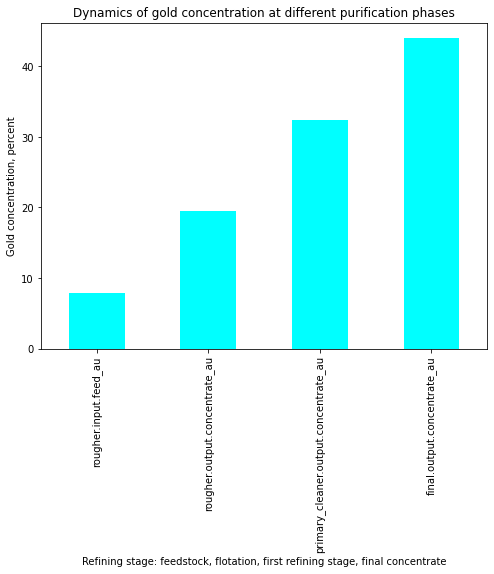

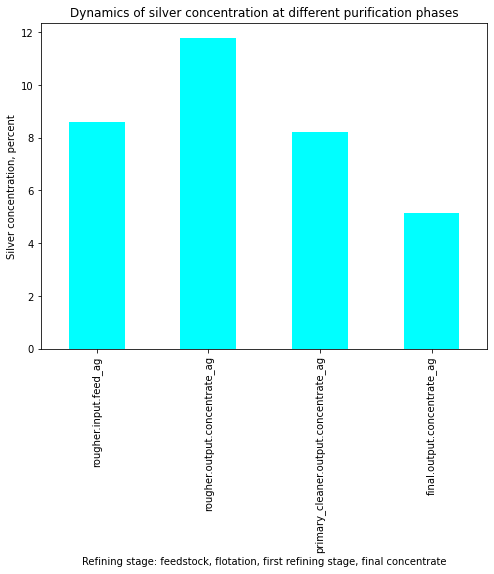

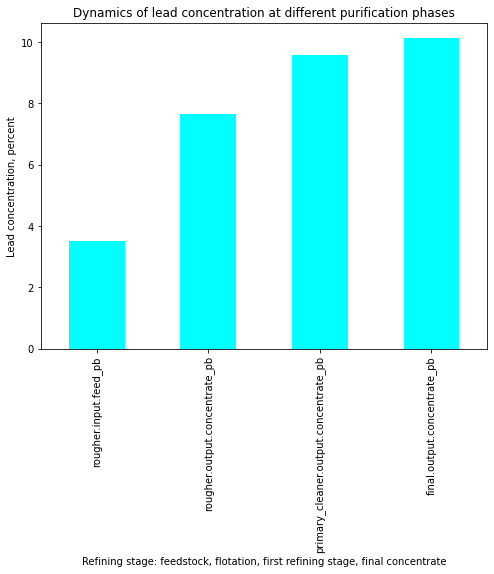

In [12]:
# График концентрации золота
train[['rougher.input.feed_au', 'rougher.output.concentrate_au',
'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']].mean().plot(figsize = (8,6), kind='bar', colormap='cool',
                   title = 'Dynamics of gold concentration at different purification phases')
plt.xlabel('Refining stage: feedstock, flotation, first refining stage, final concentrate')
plt.ylabel('Gold concentration, percent')
plt.show()

# График концентрации серебра
train[['rougher.input.feed_ag', 'rougher.output.concentrate_ag',
'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']].mean().plot(figsize = (8,6), kind='bar', colormap='cool',
                   title = 'Dynamics of silver concentration at different purification phases')
plt.xlabel('Refining stage: feedstock, flotation, first refining stage, final concentrate')
plt.ylabel('Silver concentration, percent')
plt.show()

# График концентрации свинца
train[['rougher.input.feed_pb', 'rougher.output.concentrate_pb',
'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']].mean().plot(figsize = (8,6), kind='bar', colormap='cool',
                   title = 'Dynamics of lead concentration at different purification phases')
plt.xlabel('Refining stage: feedstock, flotation, first refining stage, final concentrate')
plt.ylabel('Lead concentration, percent')
plt.show()

Based on the graphical analysis, it can be seen that lead and gold are purified qualitatively and within the framework of the technological process - the concentration of the pure substance is systematically growing from phase to phase.  
However, the process is not as efficient with silver (maybe there is some kind of process failure), because after flotation its concentration reaches its maximum, and then it only decreases. Although, in general, the goal od refining is only getting the gold, so both silver and lead can be considered as some kind of by-products.

Now let's look at the size distribution of raw materials - at the initial stage and after flotation. We will consider the distributions in each phase for the test and training samples together to see if they are similar.

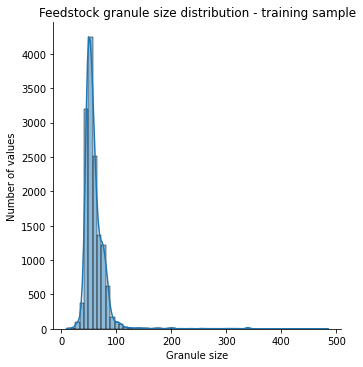

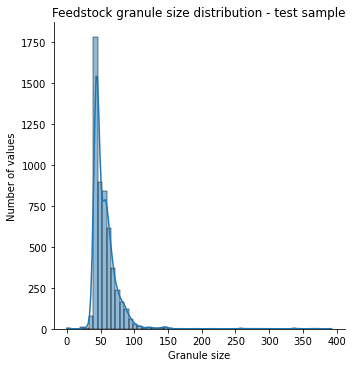

In [13]:
sns.displot(train['rougher.input.feed_size'], bins=60, kde=True)
plt.title('Feedstock granule size distribution - training sample')
plt.xlabel('Granule size')
plt.ylabel('Number of values')
plt.show()

sns.displot(test['rougher.input.feed_size'], bins=60, kde=True)
plt.title('Feedstock granule size distribution - test sample')
plt.xlabel('Granule size')
plt.ylabel('Number of values')
plt.show()

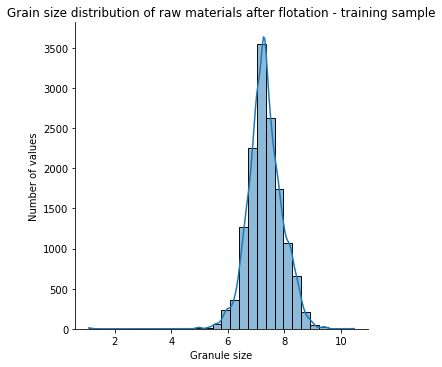

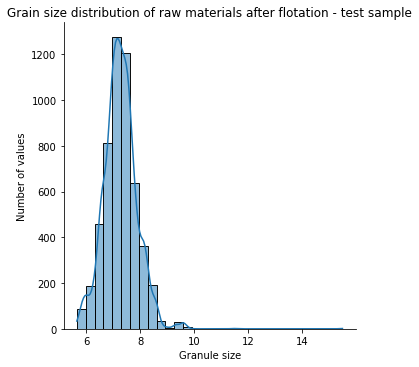

In [14]:
sns.displot(train['primary_cleaner.input.feed_size'], bins=30, kde=True)
plt.title('Grain size distribution of raw materials after flotation - training sample')
plt.xlabel('Granule size')
plt.ylabel('Number of values')
plt.show()

sns.displot(test['primary_cleaner.input.feed_size'], bins=30, kde=True)
plt.title('Grain size distribution of raw materials after flotation - test sample')
plt.xlabel('Granule size')
plt.ylabel('Number of values')
plt.show()

So, with regard to the size of the raw material granules, the distributions during training and testing are almost identical - with a very long right tail and values close to each other. As for the distributions after flotation, they have a slight difference - the feedstock shows a long left tail, and the feedstock after flotation shows a right one.     

However, this difference can be neglected (it is clearly due to the mechanics of the flotation process through which the granules passed), because the bulk of the values is distributed very close to the normal distribution and are in the same range, from 6 to 10 conventional size units.

Finally, we turn to the total concentration of all substances in the raw material, the product after flotation and the final product. To do this, we sum up the concentration of metals and substance *sol* at each of these stages, and then plot a graph for all three stages.

In [15]:
train_model['rougher.input.feed_total.calculation'] = (train['rougher.input.feed_ag'] +
                                                    train['rougher.input.feed_au'] + 
                                                    train['rougher.input.feed_pb'] +
                                                    train['rougher.input.feed_sol'])
train_model['rougher.output.concentrate_total.calculation'] = (train['rougher.output.concentrate_ag'] +
                                                    train['rougher.output.concentrate_au'] + 
                                                    train['rougher.output.concentrate_pb'] +
                                                    train['rougher.output.concentrate_sol'])
train_model['final.output.concentrate_total.calculation'] = (train['final.output.concentrate_ag'] +
                                                    train['final.output.concentrate_au'] + 
                                                    train['final.output.concentrate_pb'] +
                                                    train['final.output.concentrate_sol'])

/tmp/ipykernel_114/2206289745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_model['rougher.input.feed_total.calculation'] = (train['rougher.input.feed_ag'] +
/tmp/ipykernel_114/2206289745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_model['rougher.output.concentrate_total.calculation'] = (train['rougher.output.concentrate_ag'] +
/tmp/ipykernel_114/2206289745.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

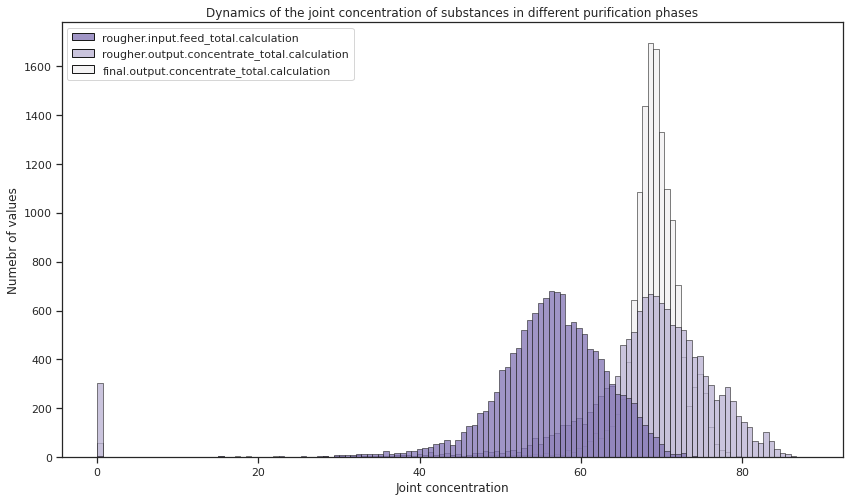

In [16]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(14, 8))
sns.histplot(train_model[['rougher.input.feed_total.calculation',
                    'rougher.output.concentrate_total.calculation',
                   'final.output.concentrate_total.calculation']], palette="light:m_r",
             edgecolor=".1")
plt.title('Dynamics of the joint concentration of substances in different purification phases')
plt.xlabel('Joint concentration')
plt.ylabel('Numebr of values')
plt.show()

### Conclusion 1

During the analysis of the data, it was found that the concentration of the pure substance increases as desired in the case of lead and gold, but decreases after flotation for silver. The size distributions of raw material granules in the test and training samples are very similar, that is, these samples are comparable and suitable for further analysis.   
Finally, the total concentration of substances in the product is distributed within the framework of logical expectations: the lowest values are evident in the feedstock (under 60%), after flotation the values increase significantly (about 70%), and in the final product the average value is approximately the same, but significantly decreases the number of outliers - that is, many more values in the sample are equal to this average than after flotation. Accordingly, the overall process seems to be working quite efficiently, despite the variance in silver. 

However, as is obvious from the last graph, there are certain anomalies in the data - and those are the lines where the joint concentration is equal to zero. That is, of course, some components can be absent, but when the sum of everything is zero, it is most probably an anomaly - and should be deleted.

In [17]:
train_model = train_model[(train_model['rougher.input.feed_total.calculation'] != 0)]
train_model = train_model[(train_model['rougher.output.concentrate_total.calculation'] != 0)]
train_model = train_model[(train_model['final.output.concentrate_total.calculation'] != 0)]

To check whether the anomalous data was removed in the final sample, we will display the graph again.

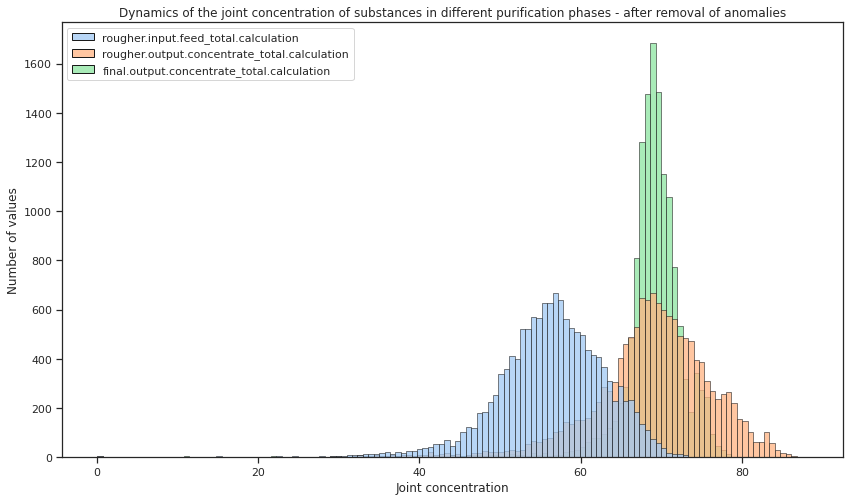

In [18]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(14, 8))
sns.histplot(train_model[['rougher.input.feed_total.calculation',
                    'rougher.output.concentrate_total.calculation',
                   'final.output.concentrate_total.calculation']], palette="pastel",
             edgecolor=".1")
plt.title('Dynamics of the joint concentration of substances in different purification phases - after removal of anomalies')
plt.xlabel('Joint concentration')
plt.ylabel('Number of values')
plt.show()

Finally, in order not to disturb the balance of the test and training samples, we remove the calculated columns.

In [19]:
train_model.drop(['rougher.input.feed_total.calculation'], axis=1, inplace=True)
train_model.drop(['rougher.output.concentrate_total.calculation'], axis=1, inplace=True)
train_model.drop(['final.output.concentrate_total.calculation'], axis=1, inplace=True)
train_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13795 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        13795 non-null  datetime64[ns]
 1   primary_cleaner.input.sulfate               13795 non-null  float64       
 2   primary_cleaner.input.depressant            13795 non-null  float64       
 3   primary_cleaner.input.feed_size             13795 non-null  float64       
 4   primary_cleaner.input.xanthate              13795 non-null  float64       
 5   primary_cleaner.state.floatbank8_a_air      13795 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_level    13795 non-null  float64       
 7   primary_cleaner.state.floatbank8_b_air      13795 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_level    13795 non-null  float64       
 9   primar

### Conclusion 2

The anomalies seen in the graphical analysis - zero values of the concentration of substances, that is, absolutely "empty" ore - have been removed, and the final sample now reflects adequate and suitable data for the study.

## Step 3. Models

Let's write a function that will calculate the sMAPE metric.

In [20]:
def smape(actual, forecast):
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

Then we divide our samples into the target and studied features. We will get two groups - *rougher* after flotation and *final* for the final product. For those under study, we will take everything except the target one, and also remove the date, because according to the format it will not work in regression.

In [21]:
# studied features
features_train_rougher = train_model.drop(['rougher.output.recovery'], axis=1).drop(['date'], axis=1)
features_train_final = train_model.drop(['final.output.recovery'], axis=1).drop(['date'], axis=1)
features_test_rougher = test.drop(['rougher.output.recovery'], axis=1).drop(['date'], axis=1)
features_test_final = test.drop(['final.output.recovery'], axis=1).drop(['date'], axis=1)

# target
target_train_rougher = train_model['rougher.output.recovery']
target_train_final = train_model['final.output.recovery']
target_test_rougher = test['rougher.output.recovery']
target_test_final = test['final.output.recovery']

As for the models, we will consider two of them - *Random Forest Regressor* and *Cat Boost Regressor*, and to compare the models, we will run the optuna package. Inside, we will apply a function to it that enumerates the parameters and evaluates the models precisely by sMAPE. We will make a selection in two stages, separately for the rough and final concentrate.

In [22]:
features_train_rougher.shape, features_test_rougher.shape

((13795, 53), (5290, 53))

### 1. Efficiency of crude concentrate enrichment

Let's start with the Cat Boost regression. Let's create an evaluation function. Here and below, *random state* or *randomm seed* is always set to 123.

In [23]:
def objective_cat(trial):
    param = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 800]), 
        'verbose': 0,
        'random_seed': 123,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 7),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3]),
        'max_depth': trial.suggest_categorical('max_depth', [2, 3, 4, 5, 6, 7, 8, 9, 10])
    }
    model = CatBoostRegressor(**param)  
    # inserting the studied parameters of the rough concentrate
    model.fit(features_train_rougher, target_train_rougher)
    # predicting
    preds = model.predict(features_test_rougher)
    # finally applying the sMAPE function
    acc = smape(target_test_rougher, preds)
    return acc

Then we will start the study itself - while setting the *direction* parameter to the minimum value (minimize), i.e. The metric measures errors, and errors should be minimal.

In [24]:
# creating optuna study
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=123))

# Let's build a model with random parameters 5 times (this is due to processing power 
# limitations, ideally 100-200 repetitions could be run)
study_cat.optimize(objective_cat, n_trials=5)

[I 2022-03-21 08:50:27,010] A new study created in memory with name: no-name-2cc20fcc-4b01-4df2-932b-a062ba360de9
[I 2022-03-21 08:50:43,302] Trial 0 finished with value: 7.111406375625611 and parameters: {'iterations': 300, 'l2_leaf_reg': 4.307888614497347, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 7.111406375625611.
[I 2022-03-21 08:50:51,273] Trial 1 finished with value: 7.218574635137494 and parameters: {'iterations': 800, 'l2_leaf_reg': 6.096590764466738, 'learning_rate': 0.01, 'max_depth': 4}. Best is trial 0 with value: 7.111406375625611.
[I 2022-03-21 08:50:58,614] Trial 2 finished with value: 7.154128748966739 and parameters: {'iterations': 800, 'l2_leaf_reg': 4.01102005530602, 'learning_rate': 0.3, 'max_depth': 4}. Best is trial 0 with value: 7.111406375625611.
[I 2022-03-21 08:52:43,106] Trial 3 finished with value: 7.237713290772308 and parameters: {'iterations': 800, 'l2_leaf_reg': 5.08780459475678, 'learning_rate': 0.01, 'max_depth': 10}. Best is 

Let's look at the number of ratings, the maximum value of the sMAPE metric, and the parameters of the best Cat Boost model.

In [25]:
print('Number of assessments completed:', len(study_cat.trials))
print('Cat boost parameters obtained at best estimate:')
cat_study = study_cat.trials_dataframe()
best_accuracy_cat = (
    cat_study.sort_values(by='value', ascending=False).reset_index(drop=True)[['value',
                                                                               'params_iterations',
                                                                               'params_l2_leaf_reg',
                                                                                'params_learning_rate', 
                                                                               'params_max_depth']]
)
best_accuracy_cat_rougher = best_accuracy_cat.rename(columns={'value': 'sMAPE'}).iloc[[0], :]
best_accuracy_cat_rougher

Number of assessments completed: 5
Cat boost parameters obtained at best estimate:


,sMAPE,params_iterations,params_l2_leaf_reg,params_learning_rate,params_max_depth
0,7.409704,500,4.566591,0.2,5


In [26]:
print('sMAPE of the best cat boost regression parameters found by optuna:', best_accuracy_cat_rougher['sMAPE'][0])

sMAPE of the best cat boost regression parameters found by optuna: 7.409704384910903


Now let's run the study again, but with the Random Forest model. We will also write a function to iterate over different parameters, but let's take another regressor - a random forest.

In [27]:
def objective_forest(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), 
        'random_state': 123,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, 30]),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 15),
        'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
        }
    model = RandomForestRegressor(**param)  
    # parameter setting
    model.fit(features_train_rougher, target_train_rougher)
    # predicting
    preds = model.predict(features_test_rougher)
    # obtaining the sMAPE
    acc = smape(target_test_rougher, preds)
    return acc

Running optuna, still minimized:

In [28]:
study_forest = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=123))
study_forest.optimize(objective_forest, n_trials=5)

[I 2022-03-21 08:52:49,551] A new study created in memory with name: no-name-a486b24a-d4b7-4bdc-a2bd-1d402807ab1e
[I 2022-03-21 08:54:01,213] Trial 0 finished with value: 7.330044635204881 and parameters: {'n_estimators': 155, 'min_samples_leaf': 3, 'max_depth': 20, 'min_samples_split': 15, 'max_features': 'auto'}. Best is trial 0 with value: 7.330044635204881.
[I 2022-03-21 08:54:05,879] Trial 1 finished with value: 7.913816598449044 and parameters: {'n_estimators': 101, 'min_samples_leaf': 8, 'max_depth': 30, 'min_samples_split': 4, 'max_features': 'log2'}. Best is trial 0 with value: 7.330044635204881.
[I 2022-03-21 08:54:09,076] Trial 2 finished with value: 8.071433603490213 and parameters: {'n_estimators': 145, 'min_samples_leaf': 9, 'max_depth': 5, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 0 with value: 7.330044635204881.
[I 2022-03-21 08:54:12,131] Trial 3 finished with value: 7.761360138202686 and parameters: {'n_estimators': 63, 'min_samples_leaf': 5, 'max

Let's look at the output - parameters and sMAPE.

In [29]:
print('Number of assessments completed:', len(study_forest.trials))
print('Random forest parameters obtained with the best estimate:')
forest_study = study_forest.trials_dataframe()
best_accuracy_forest = (
    forest_study.sort_values(by='value', ascending=False).reset_index(drop=True)[['value', 
                                                                                'params_n_estimators', 
                                                                               'params_min_samples_leaf',
                                                                               'params_max_depth',
                                                                               'params_min_samples_split',
                                                                               'params_max_features']]
)
best_accuracy_forest_rougher = best_accuracy_forest.rename(columns={'value': 'sMAPE'}).iloc[[0], :]
best_accuracy_forest_rougher

Number of assessments completed: 5
Random forest parameters obtained with the best estimate:


,sMAPE,params_n_estimators,params_min_samples_leaf,params_max_depth,params_min_samples_split,params_max_features
0,8.071434,145,9,5,7,log2


In [30]:
print('sMAPE of the best parameters found by optuna for random forest:', best_accuracy_forest_rougher['sMAPE'][0])

sMAPE of the best parameters found by optuna for random forest: 8.071433603490213


#### Model comparison

Now let's compare the obtained models by the sMAPE metric - display them in a table and graphically.

In [31]:
answer_df = pd.DataFrame(
    {'sMAPE': [best_accuracy_cat_rougher['sMAPE'][0], best_accuracy_forest_rougher['sMAPE'][0]]}, 
    index=['CatBoost_Optuna', 'RandomForest_Optuna']).sort_values(by='sMAPE', ascending=False)
answer_df['sMAPE'] = answer_df['sMAPE'].apply(lambda acc: round(acc, 3))
answer_df

,sMAPE
RandomForest_Optuna,8.071
CatBoost_Optuna,7.410


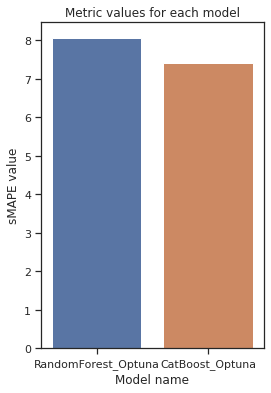

In [32]:
plt.figure(figsize=(4, 6))
sns.barplot(data=answer_df, x=[answer_df['sMAPE'].index[0], answer_df['sMAPE'].index[1]],
            y="sMAPE")
plt.xlabel('Model name')
plt.ylabel('sMAPE value')
plt.title('Metric values for each model')
plt.show()

So, for the rough concentrate, the cat boost model (500 iterations and a maximum depth of 5) showed the best result - 7.4%.

### 2. Efficiency of final concentrate enrichment

Now we will test for the final product of refining by changing the function of finding the best model - we will put all our samples there with the value *final* instead of *rougher*. As in the previous block, let's start with the cat boost regressor.

In [33]:
def objective_cat1(trial):
    param = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 800]), 
        'verbose': 0,
        'random_seed': 123,
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 7),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3]),
        'max_depth': trial.suggest_categorical('max_depth', [2, 3, 4, 5, 6, 7, 8, 9, 10])
    }
    model = CatBoostRegressor(**param)  
    model.fit(features_train_final, target_train_final)
    preds = model.predict(features_test_final)
    acc = smape(target_test_final, preds)
    return acc

# running the study for final products
study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=123))
study_cat.optimize(objective_cat1, n_trials=5)

[I 2022-03-21 08:55:21,801] A new study created in memory with name: no-name-d2555d55-4468-4a72-8453-248e408d8a1d
[I 2022-03-21 08:55:38,008] Trial 0 finished with value: 8.038708446125712 and parameters: {'iterations': 300, 'l2_leaf_reg': 4.307888614497347, 'learning_rate': 0.1, 'max_depth': 8}. Best is trial 0 with value: 8.038708446125712.
[I 2022-03-21 08:55:45,192] Trial 1 finished with value: 7.885773463598609 and parameters: {'iterations': 800, 'l2_leaf_reg': 6.096590764466738, 'learning_rate': 0.01, 'max_depth': 4}. Best is trial 1 with value: 7.885773463598609.
[I 2022-03-21 08:55:52,553] Trial 2 finished with value: 9.470779495738443 and parameters: {'iterations': 800, 'l2_leaf_reg': 4.01102005530602, 'learning_rate': 0.3, 'max_depth': 4}. Best is trial 1 with value: 7.885773463598609.
[I 2022-03-21 08:57:33,645] Trial 3 finished with value: 7.922082969126506 and parameters: {'iterations': 800, 'l2_leaf_reg': 5.08780459475678, 'learning_rate': 0.01, 'max_depth': 10}. Best is 

Printing the results:

In [34]:
print('Number of assessments completed:', len(study_cat.trials))
print('Cat boost parameters obtained at best estimate:')
cat_study = study_cat.trials_dataframe()
best_accuracy_cat = (
    cat_study.sort_values(by='value', ascending=False).reset_index(drop=True)[['value',
                                                                               'params_iterations',
                                                                               'params_l2_leaf_reg',
                                                                                'params_learning_rate', 
                                                                               'params_max_depth']]
)
best_accuracy_cat_final = best_accuracy_cat.rename(columns={'value': 'sMAPE'}).iloc[[0], :]
best_accuracy_cat_final

Number of assessments completed: 5
Cat boost parameters obtained at best estimate:


,sMAPE,params_iterations,params_l2_leaf_reg,params_learning_rate,params_max_depth
0,9.470779,800,4.01102,0.3,4


In [35]:
print('sMAPE of the best cat boost regression parameters found by optuna:', best_accuracy_cat_final['sMAPE'][0])

sMAPE of the best cat boost regression parameters found by optuna: 9.470779495738443


Now let's look at the random forest.

In [36]:
def objective_forest1(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200), 
        'random_state': 123,
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_depth': trial.suggest_categorical('max_depth', [5, 10, 20, 30]),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2, 15),
        'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
        }
    model = RandomForestRegressor(**param)  
    # parameter setting
    model.fit(features_train_final, target_train_final)
    # predicting
    preds = model.predict(features_test_final)
    # sMAPE calculation
    acc = smape(target_test_final, preds)
    return acc

In [37]:
study_forest = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=123))
study_forest.optimize(objective_forest1, n_trials=5)

[I 2022-03-21 08:57:40,043] A new study created in memory with name: no-name-9ae8d090-b113-4455-a93a-1c51a9dab18c
[I 2022-03-21 08:59:02,273] Trial 0 finished with value: 8.262233137442603 and parameters: {'n_estimators': 155, 'min_samples_leaf': 3, 'max_depth': 20, 'min_samples_split': 15, 'max_features': 'auto'}. Best is trial 0 with value: 8.262233137442603.
[I 2022-03-21 08:59:07,224] Trial 1 finished with value: 8.457341183297688 and parameters: {'n_estimators': 101, 'min_samples_leaf': 8, 'max_depth': 30, 'min_samples_split': 4, 'max_features': 'log2'}. Best is trial 0 with value: 8.262233137442603.
[I 2022-03-21 08:59:10,203] Trial 2 finished with value: 8.499869719335388 and parameters: {'n_estimators': 145, 'min_samples_leaf': 9, 'max_depth': 5, 'min_samples_split': 7, 'max_features': 'log2'}. Best is trial 0 with value: 8.262233137442603.
[I 2022-03-21 08:59:13,362] Trial 3 finished with value: 8.36871646183028 and parameters: {'n_estimators': 63, 'min_samples_leaf': 5, 'max_

And let's look at the output.

In [38]:
print('Number of assessments completed:', len(study_forest.trials))
print('Random forest parameters obtained with the best estimate:')
forest_study = study_forest.trials_dataframe()
best_accuracy_forest = (
    forest_study.sort_values(by='value', ascending=False).reset_index(drop=True)[['value', 
                                                                                'params_n_estimators', 
                                                                               'params_min_samples_leaf',
                                                                               'params_max_depth',
                                                                               'params_min_samples_split',
                                                                               'params_max_features']]
)
best_accuracy_forest_final = best_accuracy_forest.rename(columns={'value': 'sMAPE'}).iloc[[0], :]
best_accuracy_forest_final

Number of assessments completed: 5
Random forest parameters obtained with the best estimate:


,sMAPE,params_n_estimators,params_min_samples_leaf,params_max_depth,params_min_samples_split,params_max_features
0,8.49987,145,9,5,7,log2


In [39]:
print('sMAPE of the best parameters found by optuna for random forest:', best_accuracy_forest_final['sMAPE'][0])

sMAPE of the best parameters found by optuna for random forest: 8.499869719335388


#### Model comparison

As in the case of the crude concentrate, we will compare the models by the minimum value of sMAPE.

In [40]:
answer_df = pd.DataFrame(
    {'sMAPE': [best_accuracy_cat_final['sMAPE'][0], best_accuracy_forest_final['sMAPE'][0]]}, 
    index=['CatBoost_Optuna', 'RandomForest_Optuna']).sort_values(by='sMAPE', ascending=False)
answer_df['sMAPE'] = answer_df['sMAPE'].apply(lambda acc: round(acc, 3))
answer_df

,sMAPE
CatBoost_Optuna,9.471
RandomForest_Optuna,8.500


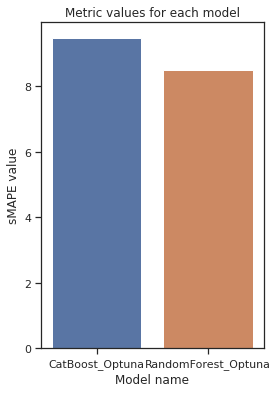

In [41]:
plt.figure(figsize=(4, 6))
sns.barplot(data=answer_df, x=[answer_df['sMAPE'].index[0], answer_df['sMAPE'].index[1]],
            y="sMAPE")
plt.xlabel('Model name')
plt.ylabel('sMAPE value')
plt.title('Metric values for each model')
plt.show()

In this case, for the final concentrate, the random forest model shows the best result (145 trees and a maximum depth of 5) - and sMAPE is 8.5%.

### Conclusion 1

As a result of model selection using the optuna software, which immediately takes into account both the training and test sets, the best model for the rough concentrate is **cat boost**, and for the final product it is a **random forest**. At the same time, the final sMAPE indicator for the entire technological process was:

In [42]:
smape_total = 0.75*best_accuracy_forest_final['sMAPE'][0] + 0.25*best_accuracy_cat_rougher['sMAPE'][0]
print(smape_total, '%')

8.227328385729267 %


However, in order to be completely sure that the model is workable, we need to run a dummy regression (in this case a median seems suitable). This will show us if there is any qualitative difference between our models and a random one.

In [46]:
dummy_regressor_rougher = DummyRegressor(strategy="median")
dummy_regressor_rougher.fit(features_train_rougher, target_train_rougher)
dummy_rougher_pred = dummy_regressor_rougher.predict(features_test_rougher)
smape_dummy_rougher = smape(target_test_rougher, dummy_rougher_pred)
print('Minimum sMAPE of random median model for crude concentrate: {:.4} %'.format(smape_dummy_rougher)) 

Minimum sMAPE of random median model for crude concentrate: 8.526 %


In [47]:
dummy_regressor_final = DummyRegressor(strategy="median")
dummy_regressor_final.fit(features_train_final, target_train_final)
dummy_final_pred = dummy_regressor_final.predict(features_test_final)
smape_dummy_final = smape(target_test_final, dummy_final_pred)
print('Minimum sMAPE of the random median model for the final concentrate: {:.4} %'.format(smape_dummy_final))  

Minimum sMAPE of the random median model for the final concentrate: 9.743 %


In [48]:
smape_total = 0.75*smape_dummy_final + 0.25*smape_dummy_rougher
print('The final sMAPE indicator for the entire technological process \nfor a random model was:', smape_total, '%')

The final sMAPE indicator for the entire technological process 
for a random model was: 9.43899456364264 %


### Conclusion 2

So, when comparing the combination of the two best models (cat boost and random forest) with the median-based dummy model, the dummy model is inferior in the sMAPE metric with 9.4% versus 8.2% for the found models. Accordingly, the found models are really efficient and can be used to predict the concentration of gold.

## General conclusion

Within this project, a prototype of a machine learning model was prepared. The model predicts the recovery factor for gold from gold ore. To obtain the model, data with production and treatment parameters were used. The project consisted of:
- data preparation (adding a target feature to the test set and formatting the training set in accordance with the test set)
- data preprocessing (filling in gaps)
- EDA (study of changes in the concentration of elements, distribution of granule sizes and total concentrations of substances at each stage)
- building, training and choosing the best model (writing a function to calculate the final *sMAPE*, training and checking cat boost and random forest regressions, choosing the best model by *sMAPE* using the optuna package)

As a result of the project, different models were chosen for the roughing and final concentrate. The *rough concentrate* (with an error of only 7.39% by sMAPE) is best predicted by a ***cat boost regression with 500 iterations and a maximum depth of 5***, and the *final gold grade* is best (sMAPE 8.5%) is modeled by a ***random forest of 145 trees with a maximum depth 5***.    

The final value of the sMAPE metric was only **8.22%**, which indicates a fairly accurate model - especially in comparison with the random median model, which showed an sMAPE of 9.44%.